In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import cpnet
from graph_tool import spectral
import regression as reg

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [2]:
raw_data = pd.read_csv('data/games.csv')
raw_data.head(2)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [3]:
def process_data(raw_data, quantile, describe=False):

    # Remove the rows with 0 values
    processed_data = raw_data[raw_data["Average playtime forever"] != 0]

    # Remove nan from genres
    processed_data = processed_data[processed_data["Genres"].notna()]

    # Getting the relevant publishers
    publisher_counts = processed_data['Publishers'].value_counts()
    popular_publishers = publisher_counts[publisher_counts > 1].index
    processed_data = processed_data[processed_data['Publishers'].isin(popular_publishers)]

    # Create a new column with the game year
    processed_data["Year"] = processed_data["Release date"].str[-4:]

    # Create a new column with the number of reviews
    processed_data["Total Reviews"] = processed_data["Positive"] + processed_data["Negative"]

    # Group by publishers and get the total of reviews
    publisher_reviews = processed_data.groupby("Publishers")["Total Reviews"].sum()
    publisher_reviews = publisher_reviews.sort_values(ascending=False)
    
    publisher_reviews = publisher_reviews[publisher_reviews > publisher_reviews.quantile(quantile)]

    # Filter data with the publishers with more than 0 reviews
    processed_data = processed_data[processed_data["Publishers"].isin(publisher_reviews.index)]

    if describe:
        print(publisher_counts.describe())
        sns.histplot(publisher_counts, binwidth = 1)
        print(publisher_reviews.describe())

    return processed_data

In [4]:
processed_data = process_data(raw_data, 0.25, describe=False)

print(f'Total de publishers: {len(processed_data["Publishers"].unique())}, Total de jogos: {len(processed_data["Name"].unique())}')

Total de publishers: 1303, Total de jogos: 8225


In [5]:
# Filtrando pelos generos que são de jogos
def get_game_genres(genre):
    return genre not in ["Early Access", "Utilities","Web Publishing", 
                         "Audio Production", "Animation & Modeling", 
                         "Video Production", "Photo Editing", "Software Training", 
                         "Design & Illustration", "Free to Play", np.nan]

def filter_genres():
    genres_list = list(filter(get_game_genres, processed_data["Genres"].str.split(",").explode().unique()))
    genres = {}
    
    for i, genre in enumerate(genres_list):
        genres[genre] = i
    return genres, genres_list

genres, genres_list = filter_genres()
len(genres), genres

(17,
 {'Strategy': 0,
  'Action': 1,
  'Adventure': 2,
  'Casual': 3,
  'Indie': 4,
  'RPG': 5,
  'Racing': 6,
  'Sports': 7,
  'Simulation': 8,
  'Sexual Content': 9,
  'Massively Multiplayer': 10,
  'Violent': 11,
  'Gore': 12,
  'Nudity': 13,
  'Education': 14,
  'Game Development': 15,
  'Accounting': 16})

In [6]:
def get_publishers_dic(print_pubs = False):
    publishers_dic = {}
    for publisher in processed_data["Publishers"].unique():
        # Get the games of the publisher
        publisher_games = processed_data[processed_data["Publishers"] == publisher]

        # Add the genres to the dictionary
        pub_genres = list(genres)
        publishers_dic[publisher] = [0] * len(genres)

        # Iterate over the games of the publisher
        for index, row in publisher_games.iterrows():

            # Iterate over the genres of the game
            #print(row["Genres"])
            for genre in row["Genres"].split(","):
                # Add 1 to the genre
                if get_game_genres(genre):
                    publishers_dic[publisher][genres[genre]] += 1

        sum_genres = sum(publishers_dic[publisher])
        for genre in pub_genres:
            # publishers_dic[publisher][genres[genre]] /= len(publisher_games)
            # print(sum_genres)
            if sum_genres != 0:
                publishers_dic[publisher][genres[genre]] /= sum_genres
            else:
                # delete the publisher key from dict
                del publishers_dic[publisher]
                break
                
    if print_pubs:
        for publisher in publishers_dic:
            print(publisher, publishers_dic[publisher])
        
    return publishers_dic

publishers_dic = get_publishers_dic()

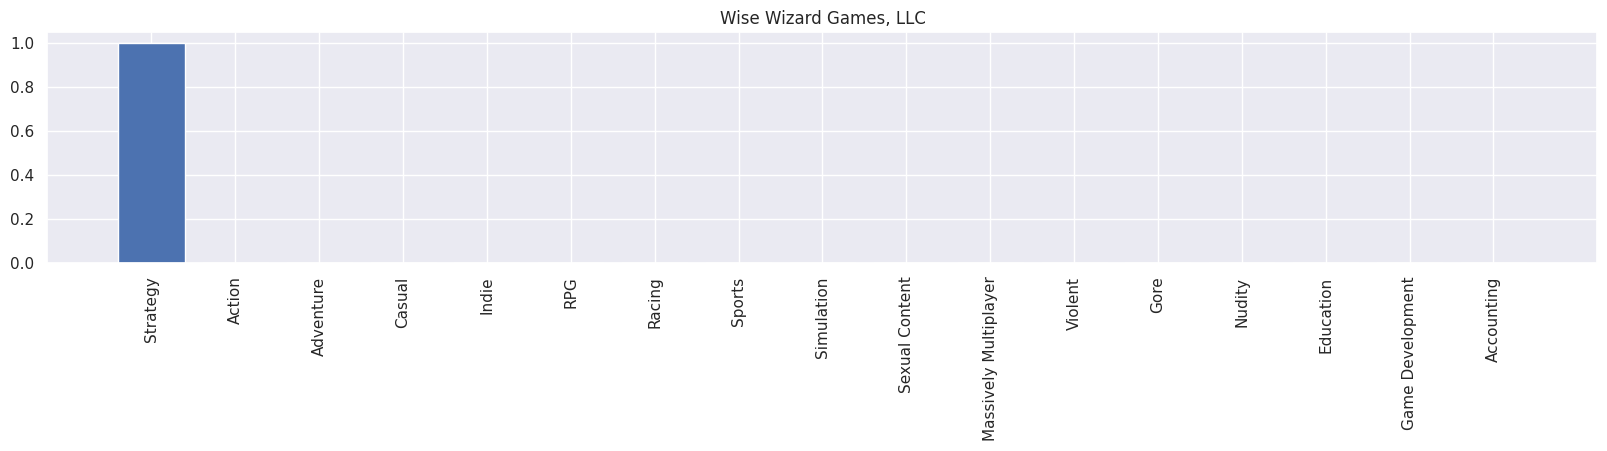

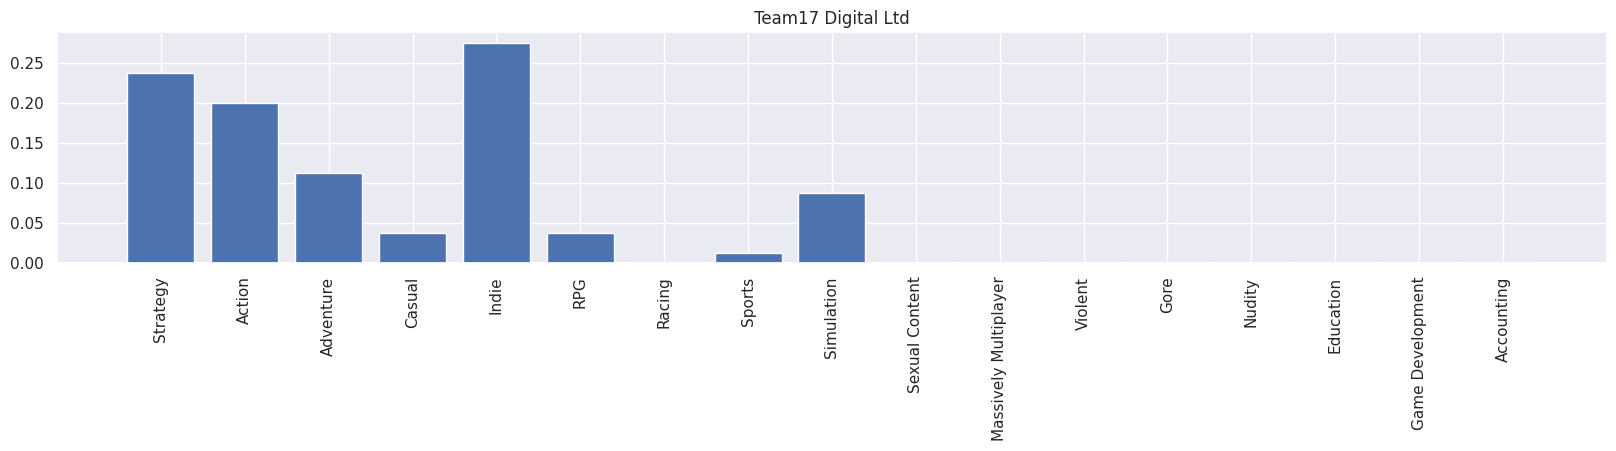

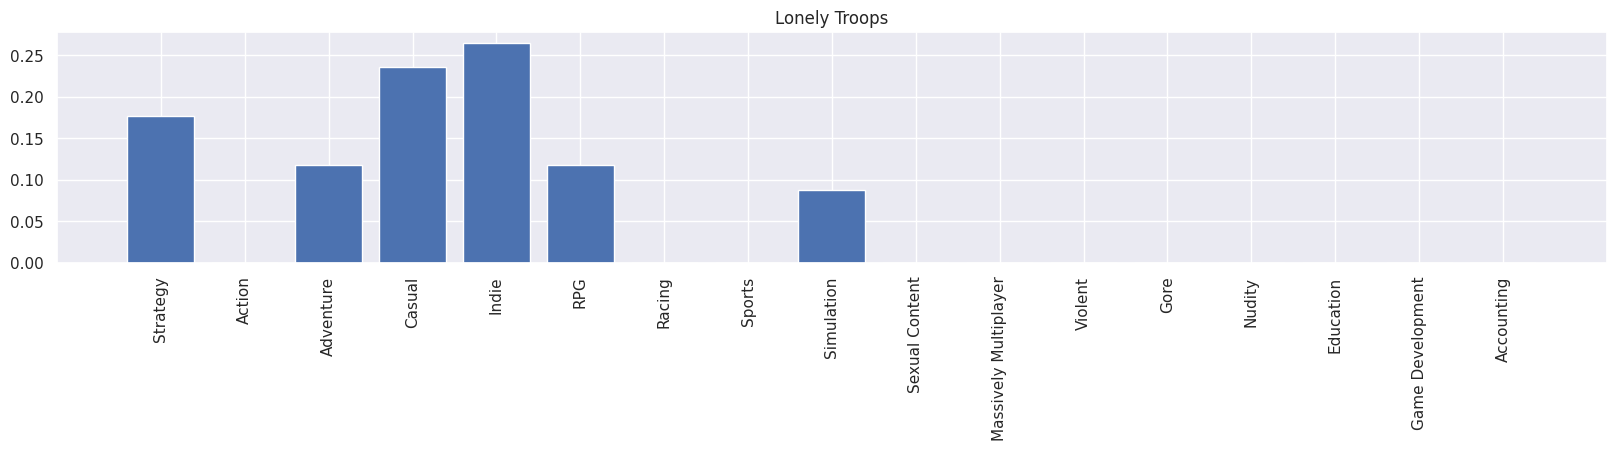

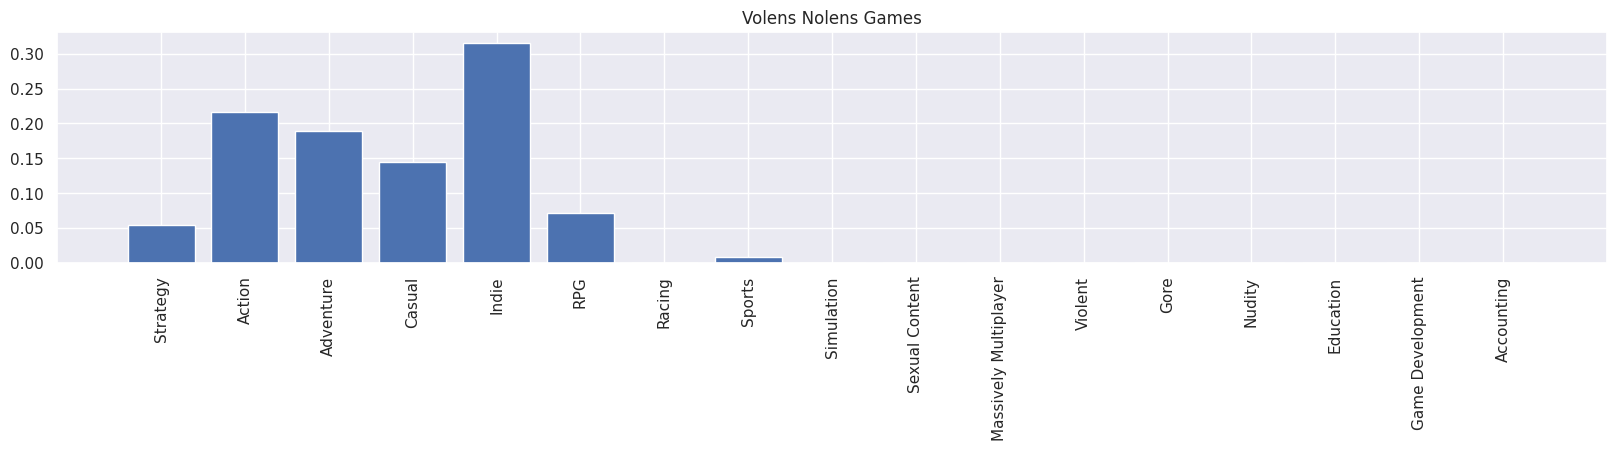

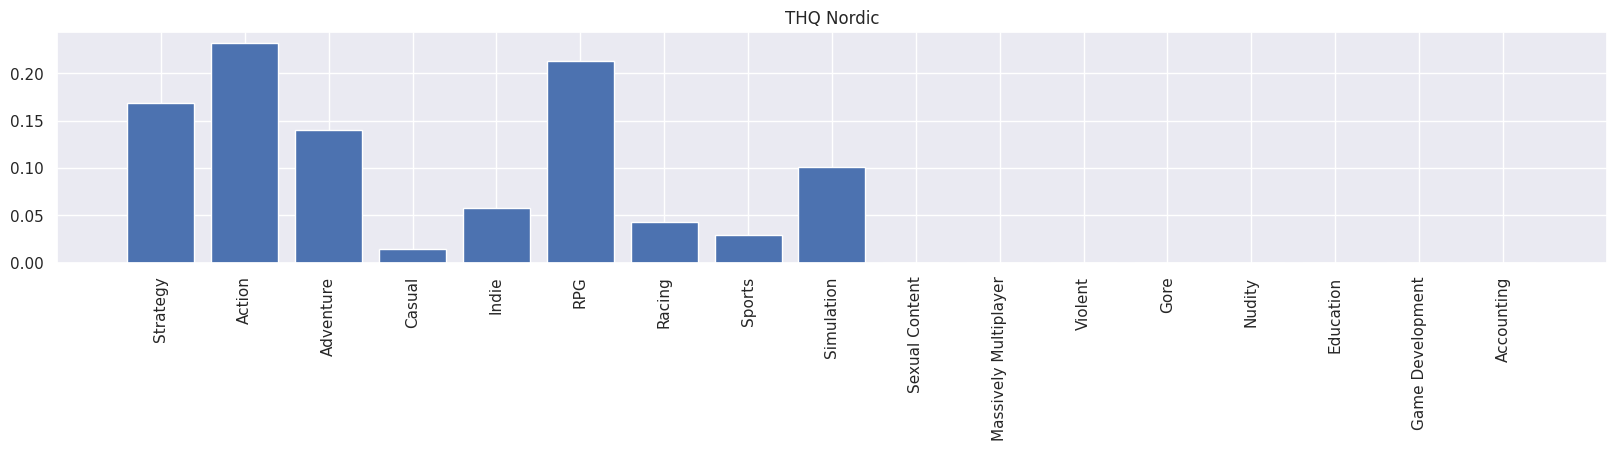

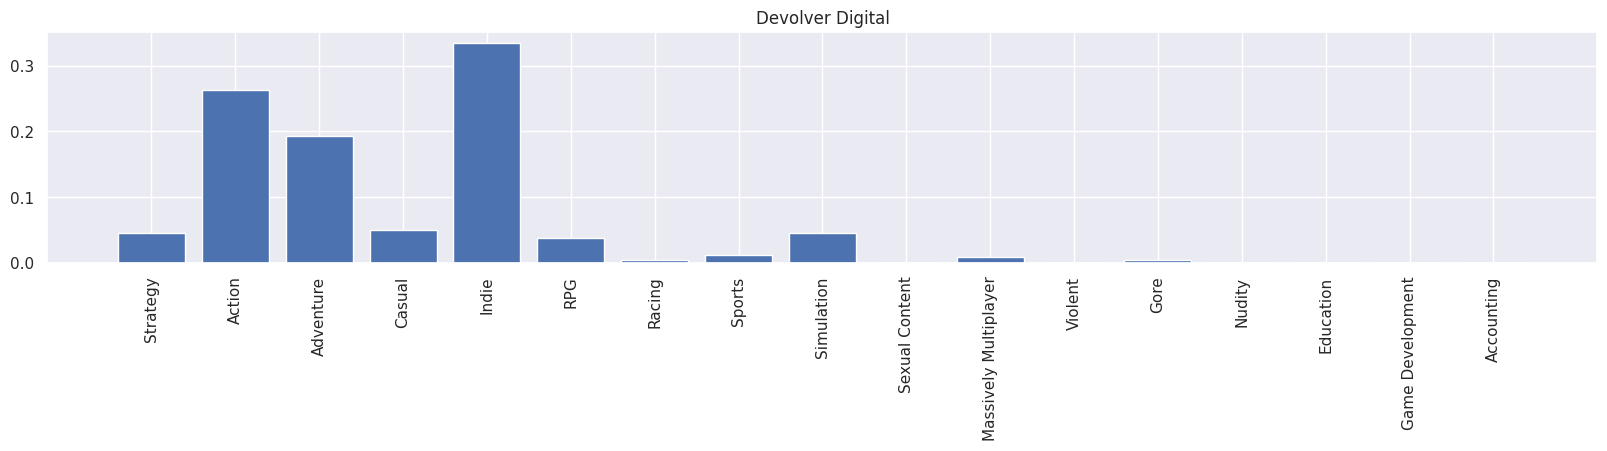

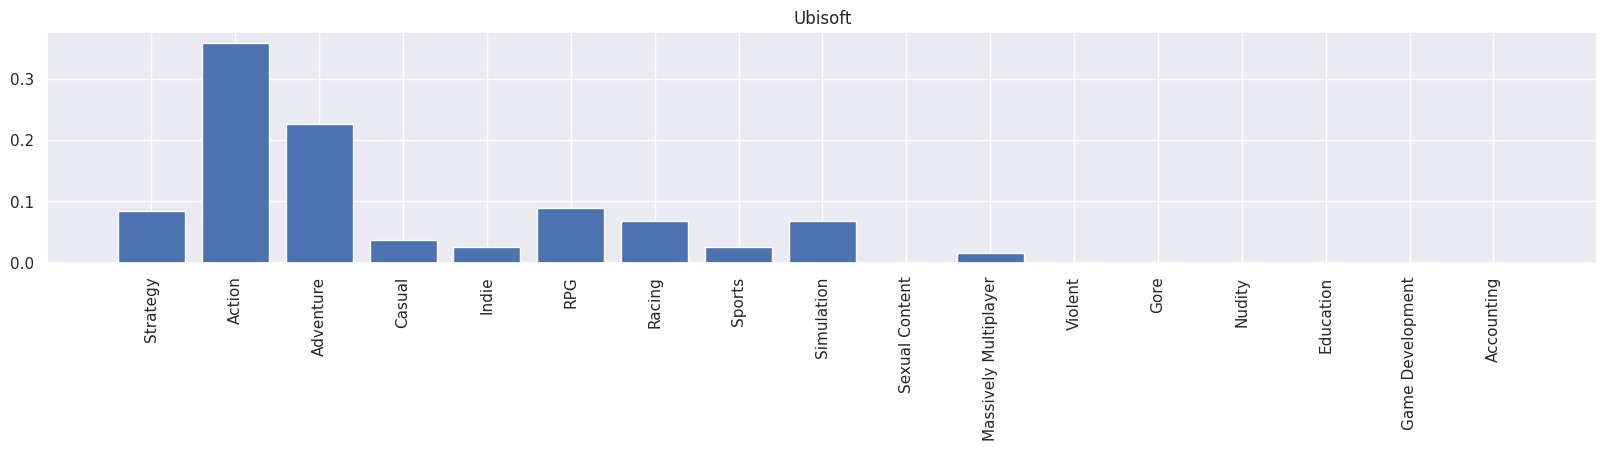

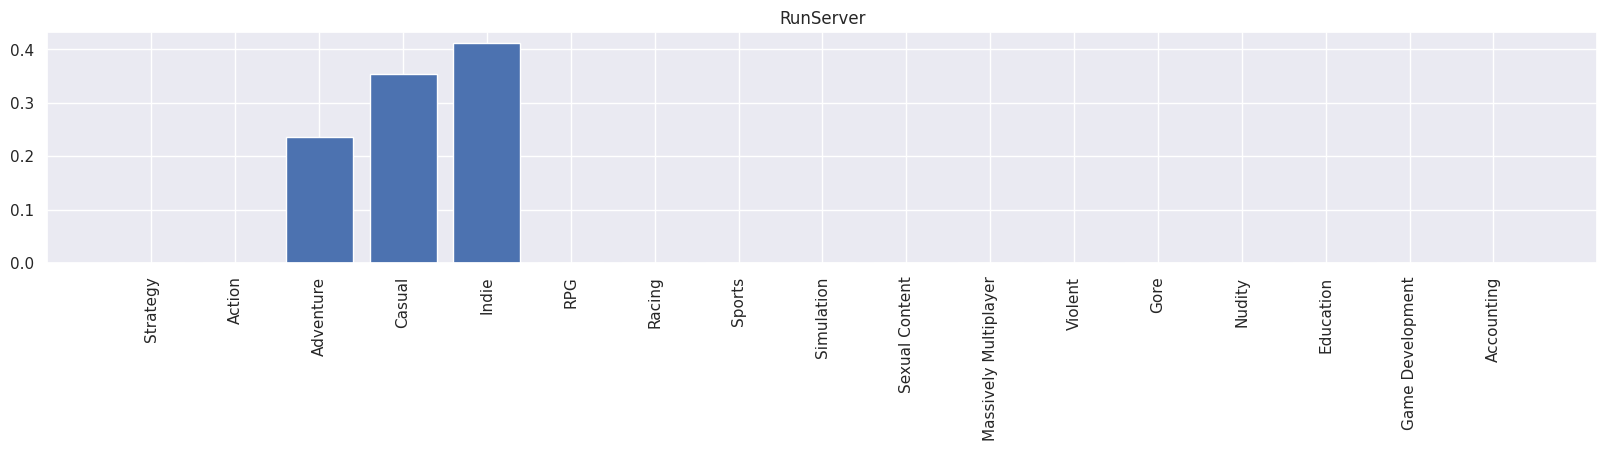

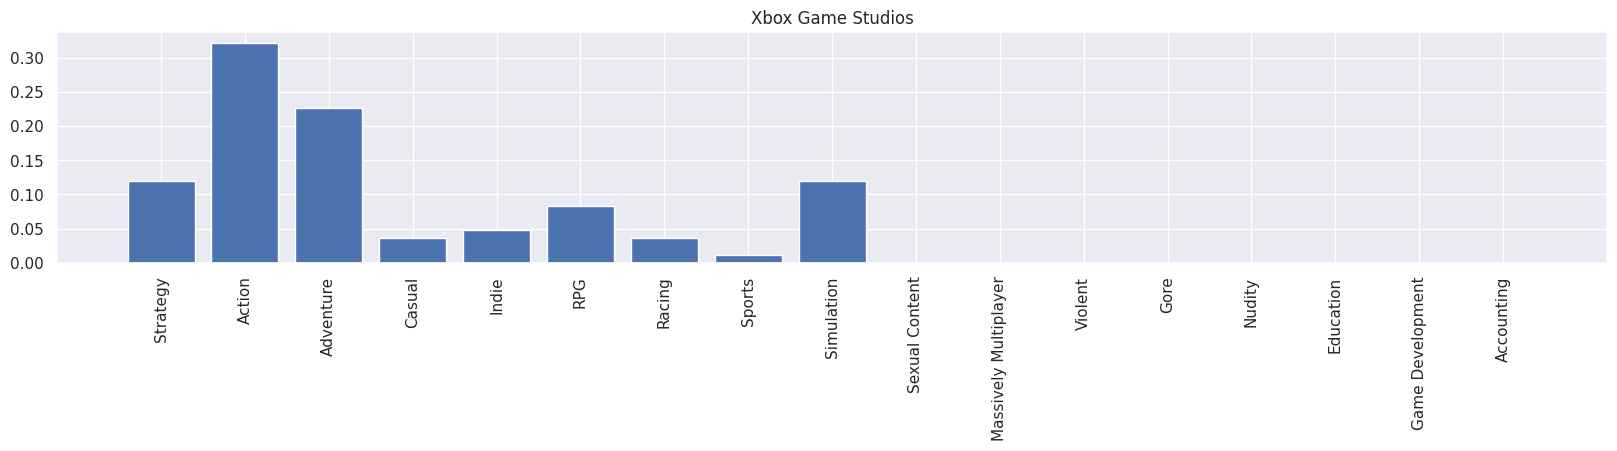

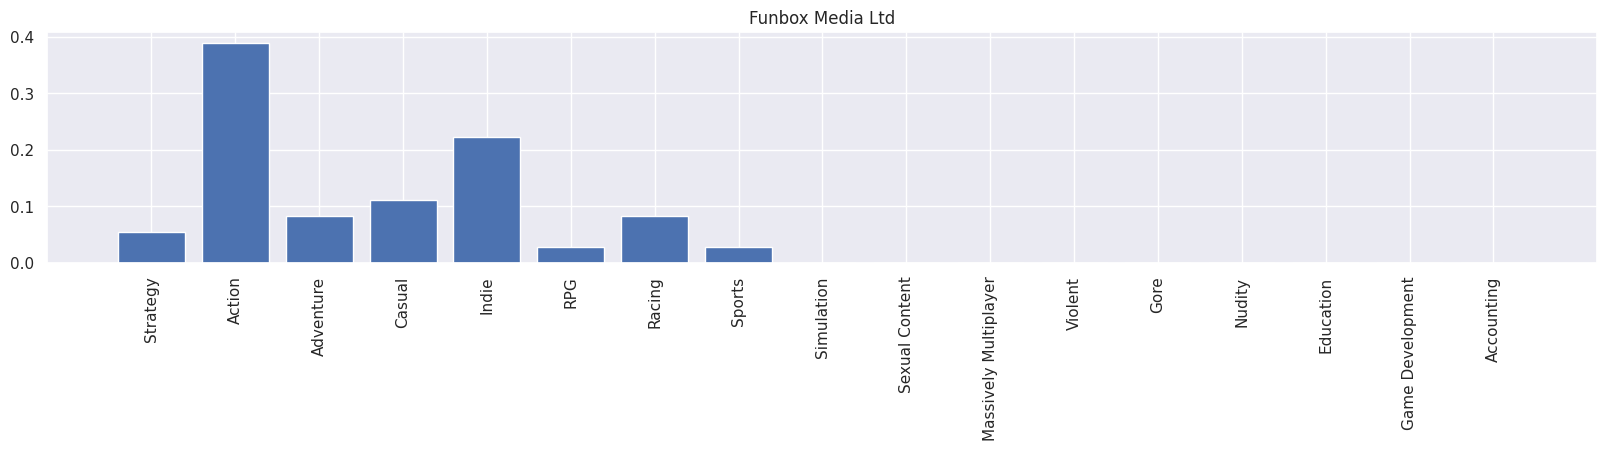

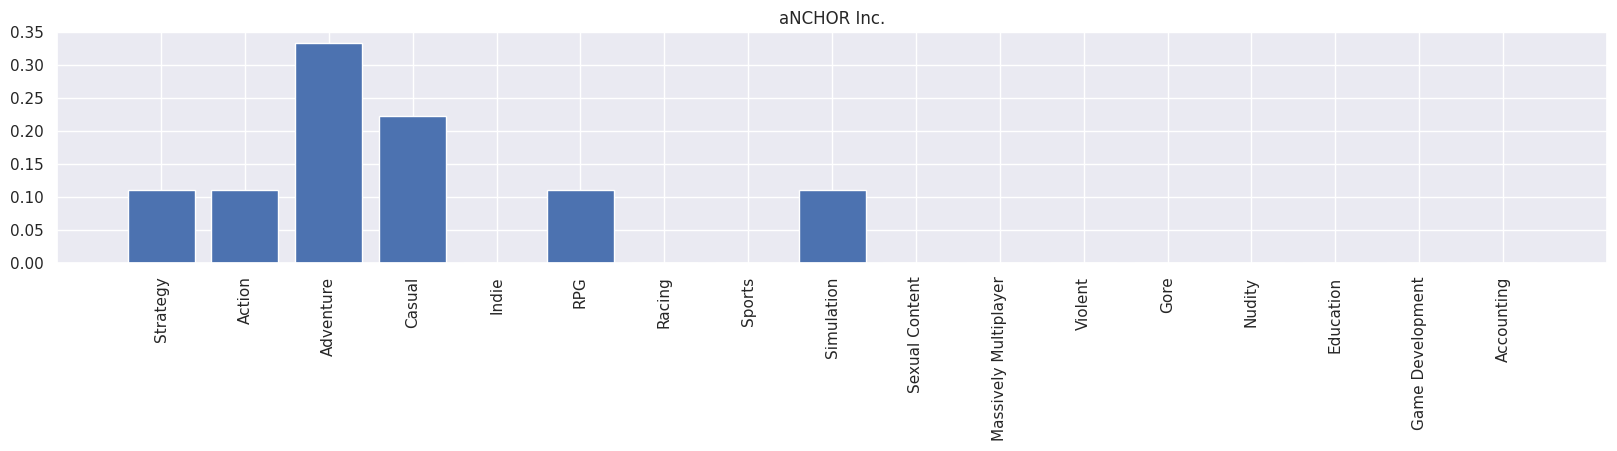

In [7]:
# Plot histograms for publishers
def plot_hists():
    count = 0
    for publisher in publishers_dic:

        plt.figure(figsize=(20, 3))
        plt.bar(genres_list, publishers_dic[publisher])
        plt.xticks(rotation=90)
        plt.title(publisher)
        plt.show()

        if count < 10:
            count += 1
        else:
            break
            
plot_hists()

In [8]:
def get_vec_distances():
    pointer = 1
    publishers_list = list(publishers_dic.keys())
    distances = []

    # Get the distance between caracteristics of publishers
    for pub1 in publishers_list:
        for pub2 in publishers_list[pointer:]:
            if pub1 != pub2:
                distance = sum([(x - y)**2 for x, y in zip(publishers_dic[pub1], publishers_dic[pub2])])**0.5
                distances.append(distance)
        pointer += 1
        
    return distances

distances = get_vec_distances()

840456 0.5360393107257586 0.5037360419902471


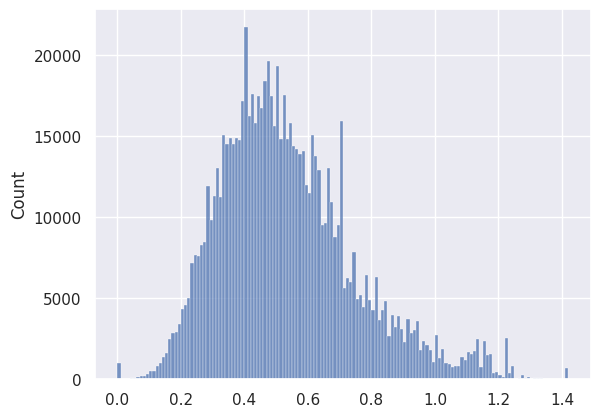

count    840456.000000
mean          0.536039
std           0.214537
min           0.000000
25%           0.384967
50%           0.503736
75%           0.655506
max           1.414214
dtype: float64


In [9]:
def get_metrics(distances_arr):
    mean, median = np.mean(distances_arr), np.median(distances_arr)
    print(len(distances_arr),mean, median)

    sns.histplot(distances_arr, binwidth=0.01)
    plt.show()

    return mean, median

mean, median = get_metrics(np.array(distances))
print(pd.Series(distances).describe())

In [10]:
def get_edges(threshold):
    pointer = 1
    publishers_list = list(publishers_dic.keys())
    edges = []


    for i1, pub1 in enumerate(publishers_list):
        for i2, pub2 in enumerate(publishers_list[pointer:]):
            if pub1 != pub2:
                distance = sum([(x - y)**2 for x, y in zip(publishers_dic[pub1], publishers_dic[pub2])])**0.5
                if distance < threshold:
                    edges.append((i1, i2 + pointer))
        pointer += 1

    print(len(edges))
    return edges, publishers_list

edges, publishers_list = get_edges(median)

420176


In [11]:
g = Graph(directed=False) # não-dirigido
g.add_vp('Name')

for i, publisher in enumerate(publishers_list):
    g.add_vertex(i)
    v = g.get_vertex(i)
    v["Name"] = publisher
    
for e in edges:
    g.add_edge(e[0], e[1])
    
g = gt_clean(g)

In [12]:
n = g.num_vertices()
print(f'O número de vértices é de {n}')

m = g.num_edges()
print(f'O número de arestas é de {m}')

max_edges = n * (n - 1) // 2

d = m / max_edges
media_arestas = m / n
print(f'A densidade é de {d}')

O número de vértices é de 1292
O número de arestas é de 420175
A densidade é de 0.5038154117695022


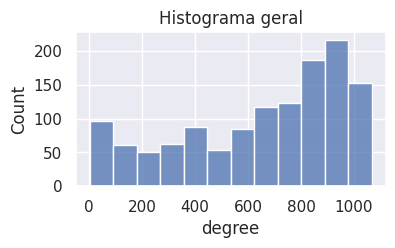

count    1292.000000
mean      650.425697
std       305.971126
min         3.000000
25%       419.000000
50%       729.500000
75%       905.000000
max      1066.000000
Name: degree, dtype: float64

In [13]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
data = gt_data(g)
data['degree'] = degrees
fig, ax = plt.subplots(figsize=(4, 2))
sns.histplot(data['degree']).set(title='Histograma geral')
plt.savefig("hist-degrees")
plt.show()
data['degree'].describe()

In [14]:
from graph_tool import clustering
from graph_tool import centrality
from graph_tool import centrality

dc = gt_total_degree(g)
bc, _ = centrality.betweenness(g)
cc = centrality.closeness(g)
lc = clustering.local_clustering(g)

g.add_vp('degree', dc)
g.add_vp('betweenness', bc)
g.add_vp('closeness', cc)
g.add_vp('clustering', lc)

matrix = spectral.adjacency(g)
algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)
    
gt_data(g)

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


,Name,degree,betweenness,closeness,clustering,coreness
id,,,,,,
0,"Wise Wizard Games, LLC",0.007746,0.000000,0.349580,1.000000,0.003388
1,Team17 Digital Ltd,0.780015,0.000800,0.804863,0.723407,0.838803
2,Lonely Troops,0.711851,0.000567,0.762102,0.746573,0.218780
3,Volens Nolens Games,0.807901,0.000829,0.823342,0.702333,0.935328
4,THQ Nordic,0.669249,0.000657,0.741528,0.758554,0.200629
...,...,...,...,...,...,...
1287,Zhongce Games,0.133230,0.000450,0.510277,0.809194,0.024685
1288,"7th Beat Games,indienova",0.016266,0.000000,0.406614,1.000000,0.017183
1289,Rayll,0.520527,0.000313,0.659346,0.815911,0.102372


In [23]:
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'games.net.gz')
#r = netpixi.render('games.net.gz');
#r = netpixi.render('games.net.gz',infinite=True);

In [22]:
#r.vertex_set_key('Name')
# r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
# r.vertex_default(color=0x000000, size=15)

# mudar a cor, a espessura e a curvatura das arestas
# r.edge_default(color=0x808080, width=.5, curve1=1, curve2=1)

#r.vertex_set_key('id')
r.vertex_scale('clustering', 5, 25)

In [19]:
g_pd = gt_data(g)
g_pd.loc[g_pd["Name"].isin(["CD PROJEKT RED", "Ubisoft", "Electronic Arts", "Activision", "Square Enix", "SEGA", "Capcom", "Bethesda Softworks", "Rockstar Games", "2K"])]

,Name,degree,betweenness,closeness,clustering,coreness
id,,,,,,
6,Ubisoft,0.598761,0.000834,0.703159,0.785671,0.154163
11,Rockstar Games,0.161890,0.000082,0.528016,0.846016,0.052759
16,SEGA,0.677769,0.000831,0.746674,0.759032,0.191433
22,Activision,0.281177,0.003542,0.571239,0.751777,0.079380
56,2K,0.513555,0.000454,0.664095,0.791851,0.138674
76,Electronic Arts,0.637490,0.000892,0.722844,0.773622,0.219264
89,Capcom,0.270333,0.000248,0.568222,0.823683,0.093417
106,Bethesda Softworks,0.186677,0.000193,0.533692,0.785097,0.046951
179,Square Enix,0.467080,0.000543,0.643249,0.809882,0.125605


### Modelos

In [23]:
#
model_data = processed_data.groupby('Publishers').agg({'Positive':'sum', 'Negative':'sum',
                           'Total Reviews': 'sum',
                            'Price':'mean',
                            'Average playtime forever':'mean',
                            'AppID':'count',
                            'Year': 'min'
                           })

# Inner join with g_pd
model_data = model_data.join(g_pd.set_index('Name'), on='Publishers')
model_data = model_data[model_data["coreness"].notna()]

# Sort by Total Reviews
model_data = model_data.sort_values(by=['Total Reviews'], ascending=False)

# Sucess
model_data['Success'] = model_data['Positive'] / model_data['Total Reviews']

# Average reviews per game
model_data['AverageReviews'] = model_data['Total Reviews'] / model_data['AppID']

# Rename attribute removing spaces and capital letters
model_data = model_data.rename(columns={'Average playtime forever': 'AveragePlaytime', 
                                        'Total Reviews': 'TotalReviews', 'AppID': 'TotalGames', 
                                        'Year': 'FirstGameYear', "degree": "Degree", 
                                        "betweenness": "Betweenness", "closeness": "Closeness", 
                                        "clustering": "Clustering", "coreness": "Coreness"})

model_data

,Positive,Negative,TotalReviews,Price,AveragePlaytime,TotalGames,FirstGameYear,Degree,Betweenness,Closeness,Clustering,Coreness,Success,AverageReviews
Publishers,,,,,,,,,,,,,,
Valve,10882766,1243601,12126367,7.375294,3920.676471,34,1998,0.082881,0.000221,0.484974,0.713631,0.034850,0.897447,356657.852941
Ubisoft,2396991,473534,2870525,18.627321,1171.723214,112,2006,0.598761,0.000834,0.703159,0.785671,0.154163,0.835036,25629.687500
Electronic Arts,1768202,408321,2176523,25.181310,1397.952381,84,2008,0.637490,0.000892,0.722844,0.773622,0.219264,0.812398,25910.988095
Bethesda Softworks,1910954,257832,2168786,22.273478,1216.217391,46,2007,0.186677,0.000193,0.533692,0.785097,0.046951,0.881117,47147.521739
"KRAFTON, Inc.",1163353,902690,2066043,26.660000,7446.666667,3,2017,0.367157,0.000272,0.603553,0.838075,0.076718,0.563083,688681.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
凝冰剑斩,629,37,666,0.990000,74.500000,2,2017,0.107668,0.000003,0.510277,0.971744,0.038722,0.944444,333.000000
Screwfly Studios,457,207,664,8.990000,132.000000,3,2013,0.475600,0.000316,0.640059,0.814024,0.091965,0.688253,221.333333
Bitlock Studio,400,259,659,0.992857,165.000000,7,2016,0.762200,0.000636,0.799876,0.736358,0.914093,0.606980,94.142857


In [46]:
max_playtime = model_data['AveragePlaytime'].max()
max_price = model_data['Price'].max()
max_total_games = model_data['TotalGames'].max()

model_data['AveragePlaytime'] = model_data['AveragePlaytime'] / max_playtime
model_data['Price'] = model_data['Price'] / max_price
# model_data['TotalGames'] = model_data['TotalGames'] / max_total_games

# publisher size variable
model_data['GamesSize'] = model_data['AveragePlaytime'] * model_data['Price'] # model_data['TotalGames']
model_data


,Unnamed: 0,Publishers,Positive,Negative,TotalReviews,Price,AveragePlaytime,TotalGames,FirstGameYear,Degree,Betweenness,Closeness,Clustering,Coreness,Success,AverageReviews,PublisherSize,GamesSize
0,0,Valve,10882766,1243601,12126367,0.122942,0.114181,0.276423,1998,0.082881,0.000221,0.484974,0.713631,0.010891,0.897447,356657.852941,3.880312e-03,0.014038
1,1,Ubisoft,2396991,473534,2870525,0.310507,0.034124,0.910569,2006,0.598761,0.000834,0.703159,0.785671,0.187561,0.835036,25629.687500,9.648078e-03,0.010596
2,2,Electronic Arts,1768202,408321,2176523,0.419758,0.040712,0.682927,2008,0.637490,0.000892,0.722844,0.773622,0.222168,0.812398,25910.988095,1.167071e-02,0.017089
3,3,Bethesda Softworks,1910954,257832,2168786,0.371287,0.035420,0.373984,2007,0.186677,0.000193,0.533692,0.785097,0.050339,0.881117,47147.521739,4.918180e-03,0.013151
4,4,"KRAFTON, Inc.",1163353,902690,2066043,0.444407,0.216867,0.024390,2017,0.367157,0.000272,0.603553,0.838075,0.083979,0.563083,688681.000000,2.350665e-03,0.096377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1287,凝冰剑斩,629,37,666,0.016503,0.002170,0.016260,2017,0.107668,0.000003,0.510277,0.971744,0.037028,0.944444,333.000000,5.821955e-07,0.000036
1288,1288,Screwfly Studios,457,207,664,0.149858,0.003844,0.024390,2013,0.475600,0.000316,0.640059,0.814024,0.092691,0.688253,221.333333,1.405084e-05,0.000576
1289,1289,Bitlock Studio,400,259,659,0.016550,0.004805,0.056911,2016,0.762200,0.000636,0.799876,0.736358,0.898649,0.606980,94.142857,4.526016e-06,0.000080
1290,1290,Cosmi Valusoft,488,169,657,0.166528,0.029715,0.024390,2008,0.015492,0.000096,0.423418,0.568421,0.018393,0.742770,219.000000,1.206914e-04,0.004948


In [66]:
# Save data
#model_data.to_csv('model_data.csv')

# Import data
#model_data = pd.read_csv('model_data.csv')

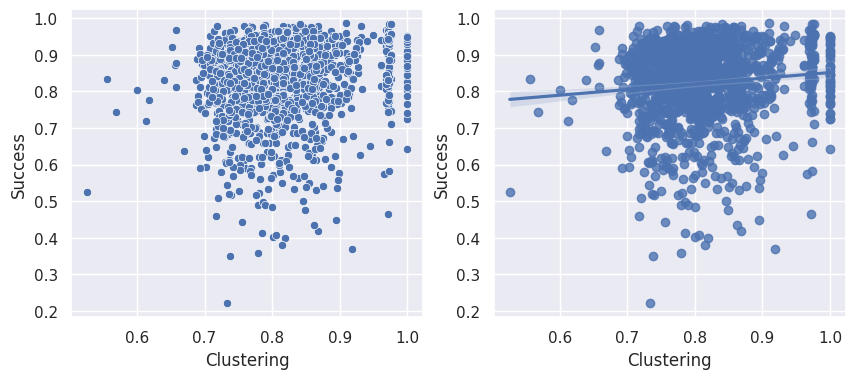

In [47]:
# Plot is side by side
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.scatterplot(x=model_data['Clustering'], y=model_data['Success'], ax=axs[0])
sns.regplot(x=model_data['Clustering'], y=model_data['Success'], ax=axs[1])
plt.show()


In [60]:
result = reg.linear(data=model_data, formula='Success ~ Clustering + GamesSize')

In [61]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Success   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.88
Date:                Mon, 29 May 2023   Prob (F-statistic):           2.06e-05
Time:                        14:13:18   Log-Likelihood:                 1031.2
No. Observations:                1292   AIC:                            -2056.
Df Residuals:                    1289   BIC:                            -2041.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6939      0.032     21.428      0.000       0.630       0.757
Clustering     0.1542      0.040      3.897      0.000       0.077       0.232
GamesSize      0.9302      0.366      2.538      0.011       0.211       1.649
==============================================================================
Omnibus:                      306.089   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.720
Skew:                          -1.321   Prob(JB):                    3.73e-146
Kurtosis:                       5.336   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
result.micro_summary()

variable,coefficient,std error,p-value
Clustering,0.154175,0.039566,0.000103
GamesSize,0.930168,0.366437,0.011252


In [63]:
result.nano_summary()

+0.154 (0.040) ***
+0.930 (0.366) **


In [64]:
# Get publisher with sucess < 0.5
model_data[model_data['Success'] < 0.5]

,Unnamed: 0,Publishers,Positive,Negative,TotalReviews,Price,AveragePlaytime,TotalGames,FirstGameYear,Degree,Betweenness,Closeness,Clustering,Coreness,Success,AverageReviews,PublisherSize,GamesSize
479,479,KPL,2993,5565,8558,0.129342,0.005130,0.105691,2014,0.766073,0.000562,0.795441,0.738375,0.946911,0.349731,658.307692,7.012962e-05,0.000664
522,522,United Independent Entertainment,3220,4035,7255,0.040413,0.009001,0.203252,2013,0.690163,0.001088,0.753649,0.756052,0.237657,0.443832,290.200000,7.393712e-05,0.000364
626,626,Reverb Triple XP,2532,2628,5160,0.190341,0.004318,0.056911,2013,0.694810,0.000426,0.756298,0.779190,0.212488,0.490698,737.142857,4.677960e-05,0.000822
691,691,Proximity Games,1966,2269,4235,0.038784,0.004029,0.024390,2016,0.254067,0.000029,0.554553,0.971955,0.053969,0.464227,1411.666667,3.810918e-06,0.000156
799,799,Akella,1214,1822,3036,0.179030,0.013520,0.032520,2011,0.210689,0.000180,0.544956,0.818917,0.047677,0.399868,759.000000,7.871609e-05,0.002421
824,824,Indie Game Group,1403,1421,2824,0.044285,0.007232,0.024390,2016,0.699458,0.000397,0.753649,0.785964,0.244676,0.496813,941.333333,7.811613e-06,0.000320
953,953,PIXOWL INC.,912,954,1866,0.041590,0.001340,0.016260,2015,0.645236,0.000472,0.721632,0.790242,0.189981,0.488746,933.000000,9.059531e-07,0.000056
984,984,Dark Day Interactive,384,1351,1735,0.033256,0.004587,0.016260,2015,0.766847,0.000817,0.799876,0.733366,0.900579,0.221326,867.500000,2.480281e-06,0.000153
1025,1025,Sunlight Games,632,893,1525,0.048453,0.007742,0.048780,2014,0.667699,0.000548,0.738136,0.784762,0.247822,0.414426,254.166667,1.829799e-05,0.000375
1045,1045,"Atomic Fabrik,Cristian Manolachi",660,774,1434,0.083181,0.007465,0.024390,2016,0.790860,0.000743,0.817089,0.716875,0.971042,0.460251,478.000000,1.514517e-05,0.000621


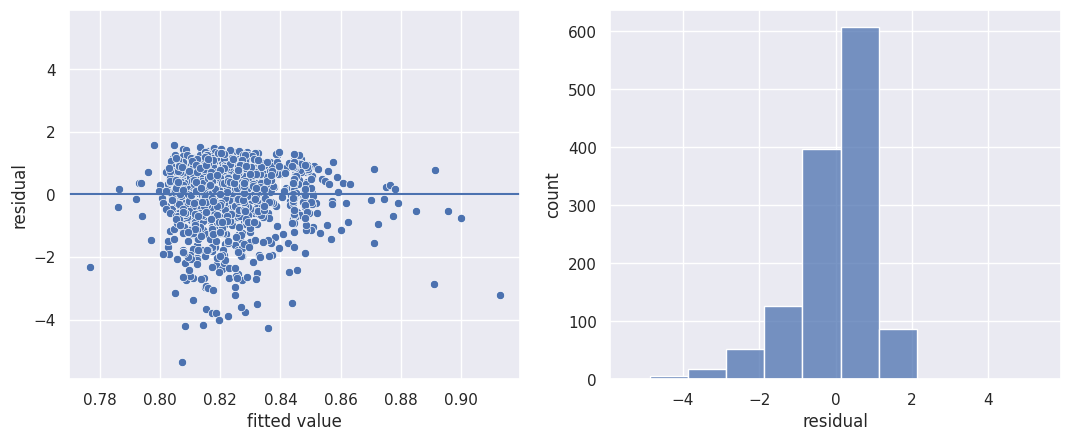

In [67]:
result.plot_residuals()